In [1]:
import os

os.chdir(globals()["_dh"][0])
print("Current working directory:", os.getcwd())
os.chdir('/home/mohammad.hallaq/workarea/MobileNet_compression') # change accordingly

Current working directory: /home/mohammad.hallaq/workarea/MobileNet_compression


In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import torch_pruning as tp
from mobilenetv3 import mobilenetv3
from collections import defaultdict
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as L
import h5py
from torch.utils.data import Dataset
import copy
import torch.nn as nn 
from tqdm import tqdm
from torchinfo import summary
import csv
from torch.profiler import profile

In [3]:
general_device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

In [4]:
# Free up cached memory
torch.cuda.empty_cache()

# Clear all the gradients
torch.cuda.reset_max_memory_allocated()

/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/torch/cuda/memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [5]:
class RFClassifier(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.lr = 1e-3
        self.lr_ignored = 1e-4  # Learning rate for ignored layers

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # Initialize lists for different parameter groups
        ignored_layers_params = []
        other_layers_params = []

        # Collect parameters of specific layers based on layer names and conditions
        ignored_params_set = set()
        for name, m in self.model.named_modules():
            if any(name.startswith(f'blocks.{i}') for i in range(3)) or (isinstance(m, torch.nn.Linear) and m.out_features == 2):
                ignored_layers_params += list(m.parameters())
                ignored_params_set.update(m.parameters())  # Add to set to avoid duplicates

        # Other parameters: Exclude the ignored layers' parameters
        other_layers_params = [p for p in self.model.parameters() if p not in ignored_params_set]

        # Create the optimizer with different learning rates for different parameter groups
        optimizer = torch.optim.AdamW([
            {'params': ignored_layers_params, 'lr': self.lr_ignored},  # Lower learning rate for ignored layers
            {'params': other_layers_params, 'lr': self.lr}  # Default learning rate for other layers
        ], weight_decay=0)

        # Learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1)

        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': lr_scheduler, 'interval': 'step'}}

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)

In [6]:
class CustomCheckpoint(L.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_validation_end(self, trainer, pl_module):
        # Access validation loss from the trainer's metrics
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = pl_module.model
            # Save the best model
            torch.save(self.best_model, 'pruning_results/best_model.pth')
            print(f"New best model saved with validation loss {val_loss:.4f}")


In [7]:
class R22_H5_Dataset(Dataset):
    def __init__(self, data_file, label='label', iqlabel='iq_data'):
        self.data_file = data_file
        self.label = label
        self.iqlabel = iqlabel

    def __len__(self):
        with h5py.File(self.data_file, 'r') as f:
            length = len(f[self.label])
        return length

    def __getitem__(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            iq_data = f[self.iqlabel][idx]
            label = f[self.label][idx]
        return iq_data, label
    
    def get_metadata(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            metadata = {
                'recording': f['recording'][idx].decode('utf-8)'),
                'category': f['category'][idx].decode('utf-8)')
            }
        return metadata


In [8]:
def prune_model(trained_model, prune_method, prune_amount, train_loader):

    # torch.manual_seed(80) 
    model =  copy.deepcopy(trained_model)
    device = general_device
    model.to(device)

    example_length = 4096

    if prune_method == 'channel_pruning_Taylor_importance':
        imp = tp.importance.TaylorImportance() 

        ignored_layers_group1 = []

        for name, m in model.named_modules():
            # Check if the module is within Sequential(3), Sequential(4), Sequential(5) or the classifier
            if any(name.startswith(f'blocks.{i}') for i in range(3)) or (isinstance(m, torch.nn.Linear) and m.out_features == 2):
                ignored_layers_group1.append(m)

        ignored_layers_group2 = []
    
        for name, m in model.named_modules():
            # Check if the module is within Sequential(0), Sequential(1), Sequential(2) or the classifier
            if any(name.startswith(f'blocks.{i+3}') for i in range(3)) or (isinstance(m, torch.nn.Linear) and m.out_features == 2):
                ignored_layers_group2.append(m) 

        batch = next(iter(train_loader))
        x, y = batch
        x = x.to(device)
       
        iterative_steps = 1
        pruner_group1 = tp.pruner.MagnitudePruner( 
            model,
            example_inputs=x,
            importance=imp,
            pruning_ratio=prune_amount, 
            ignored_layers=ignored_layers_group1,
            iterative_steps= iterative_steps,
        )

        pruner_group2 = tp.pruner.MagnitudePruner( 
            model,
            example_inputs=x,
            importance=imp,
            pruning_ratio=0.5, 
            ignored_layers=ignored_layers_group2,
            iterative_steps= iterative_steps,
        )

        # prune the model, iteratively if necessary.
        for i in range(iterative_steps):
            if isinstance(imp, tp.importance.TaylorImportance):
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                y_hat = model(x)
                loss = F.mse_loss(y_hat, y)
                loss.backward()

            pruner_group1.step()
            pruner_group2.step()

    # Free up GPU memory
    del x, y, batch  # Remove any tensors on the GPU

    torch.cuda.empty_cache()  # Clear the cache

    return model

In [8]:
# original_model_checkpoint = 'august22_beam_t.ckpt'
original_model_checkpoint = 'checkpoint_sep_data_model_state'

In [9]:
train_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/sepData_train_P100_N10.h5'
# val_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/sepData_test_P100_N10.h5'
test_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/sepData_test_P100_N10.h5'
checkpoint_dir = '/home/mohammad.hallaq/workarea/MobileNet_compression/checkpoints'
checkpoint_filename = os.path.join(checkpoint_dir, 'r22_sept15.ckpt')
checkpoint =torch.load(checkpoint_filename)
# checkpoint_dir = '/home/mohammad.hallaq/workarea/MobileNet_compression/sep_dataset_checkpoint'
# checkpoint_filename = os.path.join(checkpoint_dir, 'checkpoint_sep_data_model_state.ckpt')
# checkpoint =torch.load(checkpoint_filename)

In [10]:
example_length = 4096
batch_size = 256
epochs =30

hparams = {
    'drop_path_rate': 0.2,
    'drop_rate': 0.7,
    'learning_rate': 1e-3,
    'wd': 0.01
}

In [11]:
def train_model_with_pruning(trained_model, pruning_method, model_name_suffix, train_loader, val_loader, prune_amount):
    checkpoint_filename = f"pruning_results/model_pruned_{model_name_suffix}_amount_{prune_amount}.ckpt"
    final_model_path = f'pruning_results/model_final_pruned_{model_name_suffix}_amount_{prune_amount}.pth'

   
    if os.path.exists(checkpoint_filename) or os.path.exists(final_model_path):
        print(f"Model {model_name_suffix} at {prune_amount * 100}% pruning already exists. Skipping training.")
        return

    pruned_model = prune_model(trained_model, pruning_method, prune_amount, train_loader)

    rf_classifier = RFClassifier(pruned_model)

    checkpoint_callback = L.callbacks.ModelCheckpoint(
        dirpath='.',
        filename=checkpoint_filename.replace(".ckpt", ""),
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    
    # Create the custom callback
    custom_checkpoint = CustomCheckpoint()

    trainer = L.Trainer(
        max_epochs=30,
        callbacks=[checkpoint_callback, custom_checkpoint],
        accelerator='gpu',
        devices=[3],
        benchmark=True,
        precision='32-true',
    )

    print(f"Training the model with {pruning_method} applied at {prune_amount * 100}%...")
    trainer.fit(rf_classifier, train_loader, val_loader)

    torch.save(rf_classifier.model, final_model_path)

    print(f"Model {pruning_method} at {prune_amount * 100}% pruning saved. ")


In [10]:
# train_data = '/home/mohammad.hallaq/workarea/AoA-Pruning/data_h5py_files/r22_train.h5'
# val_data = '/home/mohammad.hallaq/workarea/AoA-Pruning/data_h5py_files/r22_test.h5'

In [9]:
# example_length = 4096
# batch_size = 128
# epochs =30

In [12]:
# train_data = '/shared/sepData_train.h5'
# val_data = '/shared/sepData_val.h5'
# test_data = '/shared/sepData_test.h5'

train_set = R22_H5_Dataset(train_data)
# val_set = R22_H5_Dataset(val_data)
test_set = R22_H5_Dataset(test_data)
print(f'Training Set: {len(train_set)} examples')
# print(f'Validation Set: {len(val_set)} examples')
print(f'Testing Set: {len(test_set)} examples')

num_classes = train_set[0][1].shape[0]

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    )
# val_loader = torch.utils.data.DataLoader(
#     dataset=val_set,
#     batch_size=128,
#     shuffle=False,
#     num_workers=8
#     )
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=128,
    shuffle=False,
    num_workers=8
    )

Training Set: 98120 examples
Testing Set: 45980 examples


In [13]:
original_model = mobilenetv3(
    model_size='mobilenetv3_small_050',
    num_classes=num_classes,
    drop_rate=hparams['drop_rate'],
    drop_path_rate=hparams['drop_path_rate'],
    in_chans=8
)

# rf_classifier = RFClassifier.load_from_checkpoint(original_model_checkpoint, model=model)

# rf_classifier.to('cuda' if torch.cuda.is_available() else 'cpu')


In [14]:
def remove_prefix_from_state_dict(state_dict, prefix='model.'):

    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix):]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [16]:
checkpoint['state_dict'] = remove_prefix_from_state_dict(checkpoint['state_dict'], prefix='model.')

original_model.load_state_dict(checkpoint['state_dict'])

# checkpoint = remove_prefix_from_state_dict(checkpoint, prefix='model.')

# original_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [15]:
#Elsayed pre-trained model

checkpoint = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/checkpoints/8oct_mobilenet_sepdata_P20Nmax_noTransform_80epochs_checkpoint_model_state_best.pth')
original_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [17]:
pruning_methods = ['channel_pruning_Taylor_importance']
pruning_amounts = [0.95]  

In [18]:
pruned_model = prune_model(original_model, pruning_methods[0], pruning_amounts[0], train_loader)
# Free up cached memory
torch.cuda.empty_cache()
example_inputs = torch.randn(1, 8, 4096)
example_inputs = example_inputs.to('cuda:3')  
macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")

MACs: 0.004203558 G, #Params: 20.087 K


In [ ]:
for method in pruning_methods:
    for amount in pruning_amounts:
        train_model_with_pruning(original_model, method, method, train_loader, val_loader, amount)


Evaluating The Pruned Model

In [28]:
pruned_model = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/best_model.pth')
example_inputs = torch.randn(1, 8, 4096)
example_inputs = example_inputs.to('cuda:3')  
macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")

MACs: 0.004203558 G, #Params: 20.087 K


In [67]:
import torch
import torch.quantization

class QuantizableModelWrapper(nn.Module):
    def __init__(self, model):
        super(QuantizableModelWrapper, self).__init__()
        self.model = model  # Your original model
        self.quant = torch.quantization.QuantStub()  # Quantization stub
        self.dequant = torch.quantization.DeQuantStub()  # Dequantization stub

    def fuse_model(self):
        # Helper function to fuse specific layers within nested modules
        def fuse_conv_bn(module, conv_name, bn_name):
            try:
                torch.quantization.fuse_modules(module, [conv_name, bn_name], inplace=True)
                print(f"Fused {conv_name} and {bn_name} in {module}")
            except Exception as e:
                print(f"Fusion failed for {conv_name} and {bn_name} in {module}: {e}")

        # Manually fuse Conv1d and GBN layers
        if hasattr(self, 'model'):
            print(f"Accessing the inner model: {type(self.model)}")

            for name, module in self.model.named_children():
                print(f"Inspecting layer: {name} - {type(module)}")

                # Fuse conv_stem and bn1 if present
                if isinstance(module, torch.nn.Conv1d) and hasattr(self.model, 'bn1'):
                    print(f"Fusing stem: conv_stem and bn1")
                    fuse_conv_bn(self.model, 'conv_stem', 'bn1')

                # Recursively fuse layers within the Sequential blocks
                if isinstance(module, torch.nn.Sequential):
                    print(f"Sequential block found: {name}")
                    for sub_name, sub_module in module.named_children():
                        print(f"Inspecting sub-layer: {sub_name} - {type(sub_module)}")
                        
                        if isinstance(sub_module, DepthwiseSeparableConv):
                            print(f"DepthwiseSeparableConv found: {sub_name}")
                            fuse_conv_bn(sub_module, 'conv_dw', 'bn1')
                            fuse_conv_bn(sub_module, 'conv_pw', 'bn2')

                        elif isinstance(sub_module, InvertedResidual):
                            print(f"InvertedResidual found: {sub_name}")
                            fuse_conv_bn(sub_module, 'conv_pw', 'bn1')
                            fuse_conv_bn(sub_module, 'conv_dw', 'bn2')
                            if hasattr(sub_module, 'conv_pwl'):
                                fuse_conv_bn(sub_module, 'conv_pwl', 'bn3')
        else:
            print("Model does not have the expected 'model' attribute.")

    def forward(self, x):
        # Quantize the input
        x = self.quant(x)
        
        # Pass through the original model
        x = self.model(x)
        
        # Dequantize the output
        x = self.dequant(x)
        return x


In [68]:
pruned_model.to('cpu')

# Initialize the wrapper around your model
quantized_model = QuantizableModelWrapper(pruned_model)

# Fuse eligible layers in the model
quantized_model.fuse_model()

Accessing the inner model: <class 'timm.models.mobilenetv3.MobileNetV3'>
Inspecting layer: conv_stem - <class 'torch.nn.modules.conv.Conv1d'>
Fusing stem: conv_stem and bn1
Fusion failed for conv_stem and bn1 in MobileNetV3(
  (conv_stem): Conv1d(8, 8, kernel_size=(3,), stride=(2,), padding=(1,))
  (bn1): GBN(
    (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv1d(8, 8, kernel_size=(3,), stride=(2,), padding=(1,), groups=8)
        (bn1): GBN(
          (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv1d(

NameError: name 'DepthwiseSeparableConv' is not defined

In [66]:
quantized_model

QuantizableModelWrapper(
  (model): MobileNetV3(
    (conv_stem): Conv1d(8, 8, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): GBN(
      (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv1d(8, 8, kernel_size=(3,), stride=(2,), padding=(1,), groups=8)
          (bn1): GBN(
            (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv1d(4, 8, kernel_size=(1,), stride=(1,))
          )
          (conv_pw): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
          (bn2): GBN(


In [25]:
# Set the quantization configuration (using default configuration)
quantized_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

# Prepare for static quantization
torch.quantization.prepare(quantized_model, inplace=True)

# Calibrate the model with a few batches from the dataset
with torch.no_grad():
    for inputs, _ in test_loader:  # Use some representative data
        inputs = inputs.to('cpu')
        quantized_model(inputs)

# Convert the model to quantized form
torch.quantization.convert(quantized_model, inplace=True)

# Test or save the quantized model
torch.save(quantized_model.state_dict(), 'quantized_model.pth')

/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [26]:
# Move the quantized model to CPU
quantized_model.to('cpu')

# Create the RFClassifier with the quantized model
rf_classifier = RFClassifier(quantized_model)

# Update the trainer to run on CPU
trainer = L.Trainer(
    max_epochs=1,
    accelerator='cpu',  # Ensure it runs on CPU
    devices=1,          # Use only one CPU
    benchmark=False,     # No need for GPU optimizations
    precision='32-true', # Precision remains true for CPU
)

# Run evaluation
trainer.test(rf_classifier, test_loader)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Testing: |          | 0/? [00:00<?, ?it/s]

NotImplementedError: Could not run 'aten::native_batch_norm' with arguments from the 'QuantizedCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::native_batch_norm' is only available for these backends: [CPU, CUDA, Meta, MkldnnCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:31419 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:44504 [kernel]
Meta: registered at /dev/null:241 [kernel]
MkldnnCPU: registered at aten/src/ATen/RegisterMkldnnCPU.cpp:515 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:324 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradHIP: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradMPS: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradIPU: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradVE: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradMTIA: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradMeta: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_1.cpp:16277 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_1.cpp:15950 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/BatchRulesNorm.cpp:864 [kernel]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:202 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:158 [backend fallback]


In [ ]:
rf_classifier = RFClassifier(pruned_model)

trainer = L.Trainer(
    max_epochs=1,
    accelerator='gpu',
    devices=[3],
    benchmark=True,
    precision='32-true',
)

trainer.test(rf_classifier, test_loader)

In [11]:
def plot_quiver(all_targets, all_outputs, quiver_path: str):
    """
    Creates and stores the quiver plot for given targets and predicted outputs
    :args all_targets:
    :args all_outputs:
    """
    predictions_per_target = defaultdict(list)
    errors_per_target = dict()

    for idx, target_angles_tuple in enumerate(all_targets):
        target_tuple = tuple(target_angles_tuple)
        predictions_per_target[target_tuple].append(all_outputs[idx])
    for target_tuple, list_of_predictions in predictions_per_target.items():
        # predictions_per_target[target_tuple] = np.mean(list_of_predictions, axis=0)
        errors_per_target[target_tuple] = np.subtract(target_tuple, np.mean(list_of_predictions, axis=0))

    unique_targets = list(errors_per_target.keys())
    unique_azimuth = [target[0] for target in unique_targets]
    unique_elevation = [target[1] for target in unique_targets]
    unique_erros = list(errors_per_target.values())
    errors_azimuth = [target[0] for target in unique_erros]
    errors_elevation = [target[1] for target in unique_erros]

    plt.figure(figsize=(10, 10))
    plt.scatter(unique_azimuth, unique_elevation, color='red', label='True Angles')
    plt.quiver(unique_azimuth, unique_elevation, errors_azimuth, errors_elevation,
                angles='xy', scale_units='xy', scale=1, color='blue', label='Predicted Angles')
    plt.xlim([-55, 55])
    plt.ylim([-55, 55])
    plt.xlabel('Azimuth')
    plt.ylabel('Elevation')
    plt.grid()
    plt.legend()
    plt.savefig(quiver_path)

Training: 100%|██████████| 384/384 [00:20<00:00, 18.37batch/s]


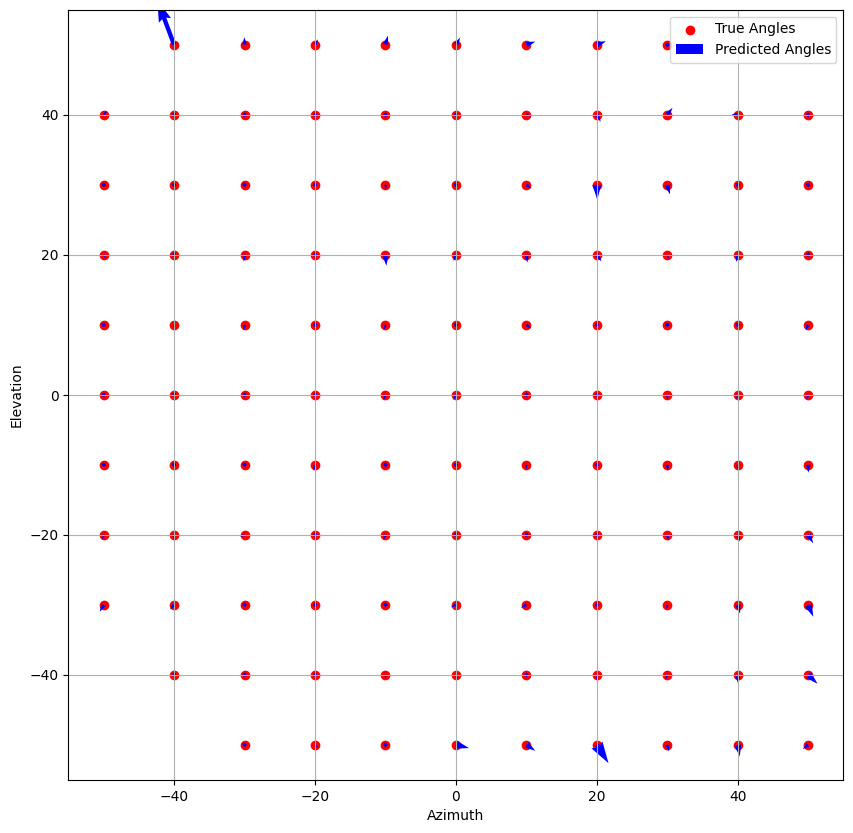

In [12]:
original_model.eval()
test_loss = 0
all_targets, all_outputs = np.zeros([1, 2]), np.zeros([1, 2])
device = general_device
experiment_path = '/home/mohammad.hallaq/workarea/AoA-Pruning/experiments'
original_model.to(device)

with torch.no_grad():
    with tqdm(train_loader, desc='Training', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs = original_model(sample_inputs)
            all_targets = np.concatenate((all_targets, targets.cpu()))
            all_outputs = np.concatenate((all_outputs, outputs.cpu()))           
    all_outputs = all_outputs[1:]
    all_targets = all_targets[1:]
    quiver_path = os.path.join(experiment_path, "training_quiver_plot.png")
    plot_quiver(all_targets, all_outputs, quiver_path)

Testing:   0%|          | 0/360 [00:00<?, ?batch/s]

Testing: 100%|██████████| 360/360 [00:13<00:00, 25.72batch/s, Val Loss=0.604]


Test Set Loss = 0.0016785163632513404


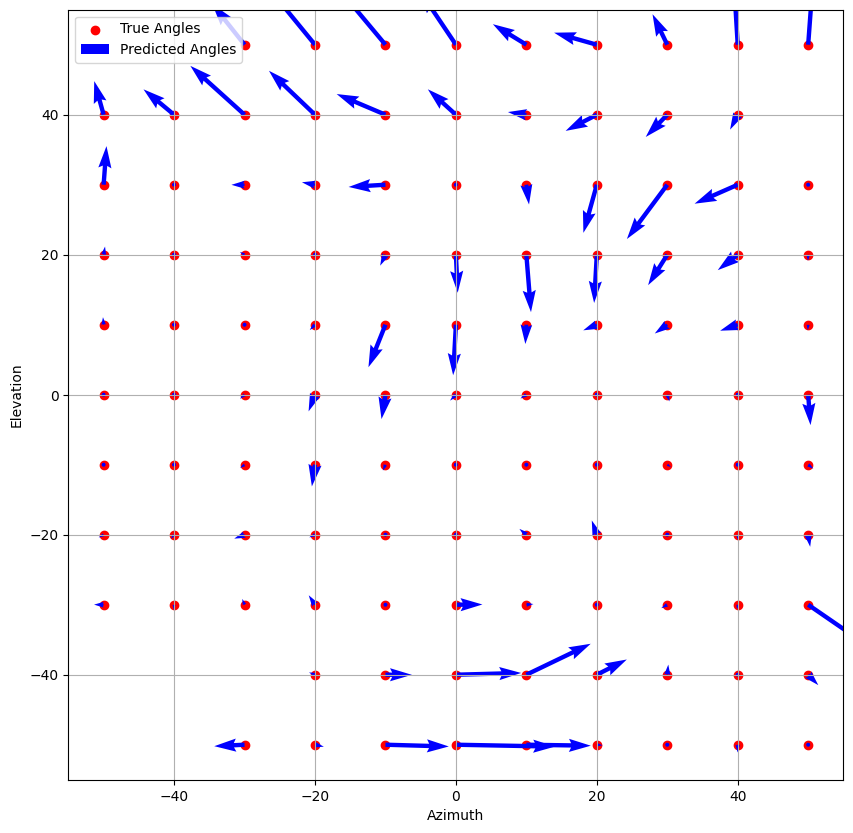

In [13]:
criterion = nn.MSELoss()
experiment_path = '/home/mohammad.hallaq/workarea/AoA-Pruning/experiments'
device = general_device
original_model = original_model.to(device)
original_model.eval()
eval_values = {'azimuth_true': [], 'azimuth_pred': [], 'elevation_true': [], 'elevation_pred': [], 'loss_value': []}

test_loss, num_samples = 0, 0
all_targets, all_outputs = np.zeros([1, 2]), np.zeros([1, 2])
with torch.no_grad():
    with tqdm(test_loader, desc='Testing', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs = original_model(sample_inputs)
            loss = criterion(outputs, targets)
            eval_values['azimuth_pred'] = targets
            num_samples += targets.shape[0]
            test_loss += loss.item()/num_samples
            all_targets = np.concatenate((all_targets, targets.cpu()))
            all_outputs = np.concatenate((all_outputs, outputs.cpu()))
            pbar.set_postfix({'Val Loss': test_loss})
    all_outputs = all_outputs[1:]
    all_targets = all_targets[1:]
    test_loss = test_loss / len(test_loader)
    print(f"Test Set Loss = {test_loss}")
    quiver_path = os.path.join(experiment_path, "testing_quiver_plot.png")
    plot_quiver(all_targets, all_outputs, quiver_path)

In [24]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

# Define both MSE and MAE criteria
mse_criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

device = general_device
pruned_model = pruned_model.to(device)
pruned_model.eval()

# Initialize dictionaries to accumulate MSE and MAE losses for each angle
angle_loss_accumulation = {
    'azimuth_mse': {angle: 0.0 for angle in range(-50, 60, 10)},
    'elevation_mse': {angle: 0.0 for angle in range(-50, 60, 10)},
    'azimuth_mae': {angle: 0.0 for angle in range(-50, 60, 10)},
    'elevation_mae': {angle: 0.0 for angle in range(-50, 60, 10)},
    'azimuth_count': {angle: 0 for angle in range(-50, 60, 10)},
    'elevation_count': {angle: 0 for angle in range(-50, 60, 10)}
}

test_mse, test_mae, num_samples = 0, 0, 0
all_targets, all_outputs = np.zeros([1, 2]), np.zeros([1, 2])

with torch.no_grad():
    with tqdm(test_loader, desc='Testing', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs = pruned_model(sample_inputs)
            
            # Calculate losses for this batch
            mse_loss = mse_criterion(outputs, targets)
            mae_loss = mae_criterion(outputs, targets)
            num_samples += targets.shape[0]

            test_mse += mse_loss.item() / num_samples
            test_mae += mae_loss.item() / num_samples

            # Convert to CPU and detach for evaluation
            outputs_np = outputs.cpu().numpy()
            targets_np = targets.cpu().numpy()

            # Accumulate MSE and MAE losses for each angle
            for i in range(targets_np.shape[0]):
                true_azimuth, true_elevation = targets_np[i]
                pred_azimuth, pred_elevation = outputs_np[i]

                azimuth_mse = (pred_azimuth - true_azimuth) ** 2
                elevation_mse = (pred_elevation - true_elevation) ** 2

                azimuth_mae = abs(pred_azimuth - true_azimuth)
                elevation_mae = abs(pred_elevation - true_elevation)

                # Accumulate losses for each azimuth and elevation value
                angle_loss_accumulation['azimuth_mse'][int(true_azimuth)] += azimuth_mse
                angle_loss_accumulation['elevation_mse'][int(true_elevation)] += elevation_mse
                angle_loss_accumulation['azimuth_mae'][int(true_azimuth)] += azimuth_mae
                angle_loss_accumulation['elevation_mae'][int(true_elevation)] += elevation_mae

                # Count occurrences of each azimuth and elevation value
                angle_loss_accumulation['azimuth_count'][int(true_azimuth)] += 1
                angle_loss_accumulation['elevation_count'][int(true_elevation)] += 1

            all_targets = np.concatenate((all_targets, targets_np))
            all_outputs = np.concatenate((all_outputs, outputs_np))

            pbar.set_postfix({'Val MSE Loss': test_mse, 'Val MAE Loss': test_mae})

    all_outputs = all_outputs[1:]
    all_targets = all_targets[1:]
    test_mse = test_mse / len(test_loader)
    test_mae = test_mae / len(test_loader)

    # Calculate average MSE and MAE loss per angle
    avg_azimuth_mse, avg_elevation_mse = {}, {}
    avg_azimuth_mae, avg_elevation_mae = {}, {}

    for angle in range(-50, 60, 10):
        if angle_loss_accumulation['azimuth_count'][angle] > 0:
            avg_azimuth_mse[angle] = angle_loss_accumulation['azimuth_mse'][angle] / angle_loss_accumulation['azimuth_count'][angle]
            avg_azimuth_mae[angle] = angle_loss_accumulation['azimuth_mae'][angle] / angle_loss_accumulation['azimuth_count'][angle]
        else:
            avg_azimuth_mse[angle] = 0.0
            avg_azimuth_mae[angle] = 0.0

        if angle_loss_accumulation['elevation_count'][angle] > 0:
            avg_elevation_mse[angle] = angle_loss_accumulation['elevation_mse'][angle] / angle_loss_accumulation['elevation_count'][angle]
            avg_elevation_mae[angle] = angle_loss_accumulation['elevation_mae'][angle] / angle_loss_accumulation['elevation_count'][angle]
        else:
            avg_elevation_mse[angle] = 0.0
            avg_elevation_mae[angle] = 0.0

    print(f"Test Set MSE Loss = {test_mse}")
    print(f"Test Set MAE Loss = {test_mae}")
    print(f"Azimuth MSE Loss by Angle: {avg_azimuth_mse}")
    print(f"Elevation MSE Loss by Angle: {avg_elevation_mse}")
    print(f"Azimuth MAE Loss by Angle: {avg_azimuth_mae}")
    print(f"Elevation MAE Loss by Angle: {avg_elevation_mae}")


Testing: 100%|██████████| 360/360 [00:08<00:00, 44.10batch/s, Val MSE Loss=0.819, Val MAE Loss=0.157]

Test Set MSE Loss = 0.002274470876823534
Test Set MAE Loss = 0.0004351161149464336
Azimuth MSE Loss by Angle: {-50: 9.322987003475694, -40: 10.776542919187596, -30: 18.10026383387895, -20: 16.549456863433246, -10: 21.514832795244196, 0: 24.590908095654108, 10: 30.98614140927396, 20: 22.04925998076995, 30: 20.074403589034393, 40: 22.30198700478166, 50: 16.003716161277318}
Elevation MSE Loss by Angle: {-50: 35.8180826386433, -40: 22.175420807542015, -30: 11.741761853081524, -20: 11.329170238164249, -10: 19.350799122395102, 0: 15.990523159724658, 10: 17.04793549554149, 20: 21.52940815298188, 30: 21.655838746416364, 40: 25.442287274968784, 50: 66.68810925520035}
Azimuth MAE Loss by Angle: {-50: 2.233998483137651, -40: 2.6764619728826706, -30: 3.1563948870334273, -20: 3.0150144710097204, -10: 3.559504486188828, 0: 3.937448875905343, 10: 4.269344477220015, 20: 3.8278021916811045, 30: 3.6294917214471853, 40: 3.962026115834288, 50: 3.006088425853465}
Elevation MAE Loss by Angle: {-50: 5.026691

In [25]:
def calculate_average_deviation(loader, model):
    device = next(model.parameters()).device
    model.to(device)
    total_azimuth_deviation = 0
    total_elevation_deviation = 0
    num_samples = 0
    with torch.no_grad():
        for batch in loader:
            inputs, true_angles = batch
            inputs, true_angles = inputs.to(device), true_angles.to(device)
            predicted = model(inputs).cpu().numpy()
            true_angles = true_angles.cpu().numpy()
            azimuth_deviation = np.abs(predicted[:, 0] - true_angles[:, 0])
            elevation_deviation = np.abs(predicted[:, 1] - true_angles[:, 1])
        
            total_azimuth_deviation += np.sum(azimuth_deviation)
            total_elevation_deviation += np.sum(elevation_deviation)
            num_samples += len(true_angles)
    avg_azimuth_deviation = total_azimuth_deviation / num_samples
    avg_elevation_deviation = total_elevation_deviation / num_samples
    return avg_azimuth_deviation, avg_elevation_deviation

In [31]:
avg_azim_dev, avg_elev_dev = calculate_average_deviation(val_loader, pruned_model)
print(avg_azim_dev, avg_elev_dev)

2.4380250465029167 2.6354439758350545
